## Deep Learning Fashionmnist

This project focuses on training and evaluating a compact convolutional neural network (CNN) and multi layer perceptron (MLP) to classify images from the FashionMNIST dataset (`torchvision.datasets.FashionMNIST`). To ensure efficient use of limited computational resources, the model is trained on a custom-defined subset of the dataset. This involves implementing a custom `Dataset` class tailored to our specific data requirements. The notebook provides a detailed walkthrough of the entire process.

![Sample Predictions](figures/example_figure.png)


## Import Libraries

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from collections import Counter
import matplotlib.pyplot as plt
import random
import numpy as np
from fmnist import FMNIST
import torch
import torch.optim as optim
from networks import CNN, MLP      
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from networks_lightning import LightningModel
import pytorch_lightning as pl
import matplotlib.image as mpimg

## Exploring the Dataset

In [ ]:
# Load the dataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load training and testing datasets
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [ ]:
# Count Instances

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

# Count instances per class in training dataset (unrestricted)
train_labels = [label for _, label in train_dataset]
train_counter = dict(sorted((Counter(train_labels)).items()))
train_counter_named = {class_names[key]: value for key, value in train_counter.items()}

# Count instances per class in testing dataset (unrestricted)
test_labels = [label for _, label in test_dataset]
test_counter = dict(sorted((Counter(test_labels)).items()))
test_counter_named = {class_names[key]: value for key, value in test_counter.items()}

print("Training instances per class:", train_counter_named)
print("Testing instances per class:", test_counter_named,end="\n\n")

# Count instances per class (restricted)
restricted_classes = ["T-shirt/top", "Trouser", "Pullover", "Sneaker", "Bag", "Ankle Boot"] 

restricted_train_count = {category: train_counter_named[category] for category in restricted_classes}
restricted_test_count = {category: test_counter_named[category] for category in restricted_classes}

print("Restricted Training instances:", restricted_train_count)
print("Restricted Testing instances:", restricted_test_count,end="\n\n")


# Total instances in unrestricted mode
total_train_instances = sum(train_counter.values())
total_test_instances = sum(test_counter.values())

print("Total Training instances (unrestricted):", total_train_instances)
print("Total Testing instances (unrestricted):", total_test_instances,end="\n\n")


# Total instances in restricted mode
total_restricted_train_instances = sum(restricted_train_count.values())
total_restricted_test_instances = sum(restricted_test_count.values())

print("Total Training instances (restricted):", total_restricted_train_instances)
print("Total Testing instances (restricted):", total_restricted_test_instances)

Training instances per class: {'T-shirt/top': 6000, 'Trouser': 6000, 'Pullover': 6000, 'Dress': 6000, 'Coat': 6000, 'Sandal': 6000, 'Shirt': 6000, 'Sneaker': 6000, 'Bag': 6000, 'Ankle Boot': 6000}
Testing instances per class: {'T-shirt/top': 1000, 'Trouser': 1000, 'Pullover': 1000, 'Dress': 1000, 'Coat': 1000, 'Sandal': 1000, 'Shirt': 1000, 'Sneaker': 1000, 'Bag': 1000, 'Ankle Boot': 1000}

Restricted Training instances: {'T-shirt/top': 6000, 'Trouser': 6000, 'Pullover': 6000, 'Sneaker': 6000, 'Bag': 6000, 'Ankle Boot': 6000}
Restricted Testing instances: {'T-shirt/top': 1000, 'Trouser': 1000, 'Pullover': 1000, 'Sneaker': 1000, 'Bag': 1000, 'Ankle Boot': 1000}

Total Training instances (unrestricted): 60000
Total Testing instances (unrestricted): 10000

Total Training instances (restricted): 36000
Total Testing instances (restricted): 6000


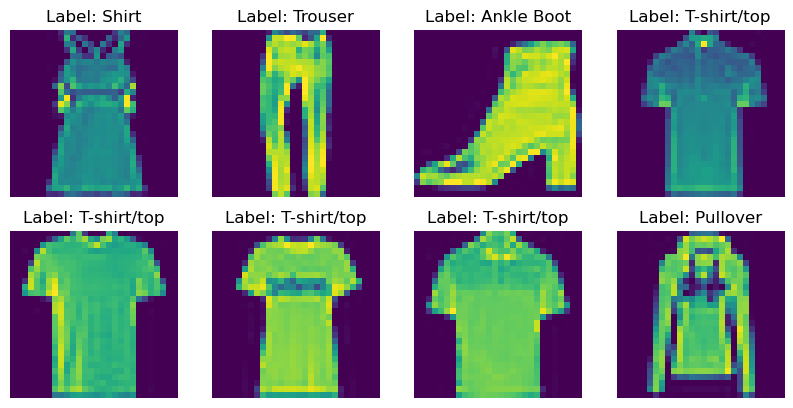

In [ ]:
def show_examples(dataset, num_samples=8):

    random.seed(42)
    
    # Randomly select indices
    indices = random.sample(range(len(dataset)), num_samples)
    
    plt.figure(figsize=(10,10))
    for i, index in enumerate(indices):
        img, label = dataset[index]
        img = img / 2 + 0.5     # Unnormalize
        
        plt.subplot(4, 4, i+1)
        plt.imshow(img.permute(1,2,0)) # Change dimensions for plotting (C,H,W) -> (H,W,C)
        plt.title(f'Label: {class_names[label]}')
        plt.axis('off')
    plt.show()

show_examples(train_dataset)

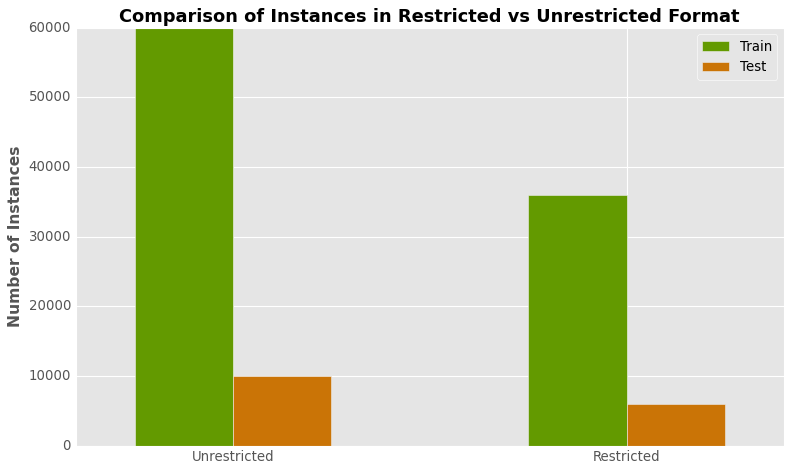

In [ ]:
# Plot the distribution of train and test instances
# Data preparation
labels = ['Unrestricted', 'Restricted']
train_values = [total_train_instances, total_restricted_train_instances]
test_values = [total_test_instances, total_restricted_test_instances]

def plot_grouped_instance_comparison(labels, train_values, test_values):

    plt.style.use('ggplot') 

    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots(figsize=(10, 6))

    bars1 = ax.bar(x - width/2, train_values, width, label='Train', color='#639A00')
    bars2 = ax.bar(x + width/2, test_values, width, label='Test', color='#CA7406')

    ax.set_ylabel('Number of Instances', fontsize=14, fontweight='bold')
    ax.set_title('Comparison of Instances in Restricted vs Unrestricted Format', fontsize=16, fontweight='bold')
    
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    
    ax.legend(fontsize=12)

    ax.yaxis.grid(True)

    plt.tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()
    
    plt.show()


plot_grouped_instance_comparison(labels, train_values, test_values)

## Define a Dataset Class

Training instances per class: {'T-shirt/top': 6000, 'Trouser': 6000, 'Pullover': 6000, 'Sneaker': 6000, 'Bag': 6000, 'Ankle Boot': 6000}
Testing instances per class: {'T-shirt/top': 1000, 'Trouser': 1000, 'Pullover': 1000, 'Sneaker': 1000, 'Bag': 1000, 'Ankle Boot': 1000}

Total number of train instances: 36000
Total number of test instances: 6000

Test is_train method for test dataset: False


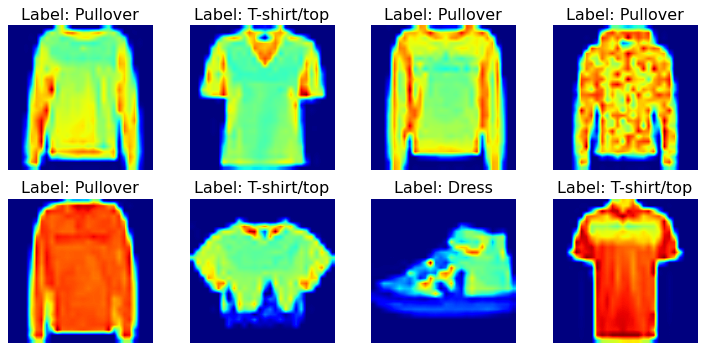

In [ ]:
# Load datasets
train_dataset = FMNIST(train=True)
test_dataset = FMNIST(train=False)


# Count occurrences of each label in the training dataset
train_counter = Counter(train_dataset.labels)
test_counter = Counter(test_dataset.labels)

train_counter_named = {name: train_counter[i] for i, name in enumerate(train_dataset.label_dict.values())}
test_counter_named = {name: test_counter[i] for i, name in enumerate(test_dataset.label_dict.values())}


print("Training instances per class:", train_counter_named)
print("Testing instances per class:", test_counter_named,end="\n\n")

print("Total number of train instances:",len(train_dataset))
print("Total number of test instances:",len(test_dataset),end="\n\n")

# Test is_train method
print("Test is_train method for test dataset:",test_dataset.is_train)

# Plotting examples using show_examples function defined earlier
show_examples(train_dataset)

## Define a Neural Network

In [ ]:
# Load datasets
train_dataset = FMNIST(train=True)
test_dataset = FMNIST(train=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Initialize model and optimizer
# model = MLP()
model = CNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop 
for epoch in range(5):   # Number of epochs
    model.train()         
    
    running_loss = 0.0
    
    for images, labels in train_loader:
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/5], Loss: {running_loss/len(train_loader):.4f}')

# Evaluation on test set
model.eval()  

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100

print(f'Accuracy on test set: {accuracy:.2f}%')

Epoch [1/5], Loss: 0.1884
Epoch [2/5], Loss: 0.1155
Epoch [3/5], Loss: 0.1015
Epoch [4/5], Loss: 0.0905
Epoch [5/5], Loss: 0.0777
Accuracy on test set: 96.53%


## Define a Lightning Module

In [ ]:
# Load datasets
full_train_dataset = FMNIST(train=True)
full_test_dataset = FMNIST(train=False)

# Split full_train_dataset into training and validation datasets
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=4)
test_loader = DataLoader(full_test_dataset, batch_size=64, num_workers=4)

# Initialize model and lightning module
model_instance = CNN()
# model_instance = MLP()
lightning_model = LightningModel(model=model_instance)

trainer = pl.Trainer(max_epochs=5)

trainer.fit(lightning_model, train_loader, val_loader)

trainer.test(lightning_model, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params
------------------------------------------------------
0 | model          | CNN                | 421 K 
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
3 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.685     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9753333330154419
        test_loss           0.07035823166370392
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.07035823166370392, 'test_acc': 0.9753333330154419}]

## Putting Everything Together

In [ ]:
!python project_main.py --train --evaluate


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

       Test metric             DataLoader 0

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

        test_acc             0.971833348274231

        test_loss           0.10348788648843765

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs\CNN without any rotation

  | Name           | Type               | Params
------------------------------------------------------
0 | model          | CNN                | 421 K 
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
3 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.685     Total estimated model params size (MB)


In [7]:

!python project_main.py --train --model-type MLP

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs\MLP without any rotation

  | Name           | Type               | Params
------------------------------------------------------
0 | model          | MLP                | 109 K 
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
3 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.437     Total estimated model params size (MB)


In [8]:
!python project_main.py --evaluate --model-type MLP --checkpoint "lightning_logs\MLP without any rotation\version_0\checkpoints\epoch=5-step=5400.ckpt"

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

       Test metric             DataLoader 0

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

        test_acc            0.9610000252723694

        test_loss           0.13543830811977386

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Part 6: Adding Rotation

In [9]:
# Test --rotate-test with CNN
!python project_main.py --train --evaluate --rotate-test

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

       Test metric             DataLoader 0

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

        test_acc            0.3606666624546051

        test_loss            7.742171287536621

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs\CNN with test rotation

  | Name           | Type               | Params
------------------------------------------------------
0 | model          | CNN                | 421 K 
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
3 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.685     Total estimated model params size (MB)


In [10]:
# Test --rotate-test with MLP
!python project_main.py --train --evaluate --model-type MLP --rotate-test

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

       Test metric             DataLoader 0

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

        test_acc            0.3395000100135803

        test_loss            7.342436790466309

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs\MLP with test rotation

  | Name           | Type               | Params
------------------------------------------------------
0 | model          | MLP                | 109 K 
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
3 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.437     Total estimated model params size (MB)


In [11]:
# Test --rotate-train and --rotate-test with CNN
!python project_main.py --train --evaluate --rotate-test --rotate-train

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

       Test metric             DataLoader 0

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

        test_acc            0.9588333368301392

        test_loss           0.1170416995882988

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs\CNN with train and test rotation

  | Name           | Type               | Params
------------------------------------------------------
0 | model          | CNN                | 421 K 
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
3 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.685     Total estimated model params size (MB)


In [12]:
# Test --rotate-train and --rotate-test with MLP
!python project_main.py --train --evaluate --rotate-test --rotate-train --model-type MLP

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

       Test metric             DataLoader 0

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

        test_acc            0.9391666650772095

        test_loss           0.18089589476585388

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs\MLP with train and test rotation

  | Name           | Type               | Params
------------------------------------------------------
0 | model          | MLP                | 109 K 
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
3 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.437     Total estimated model params size (MB)


## Tensorboard Visualizations

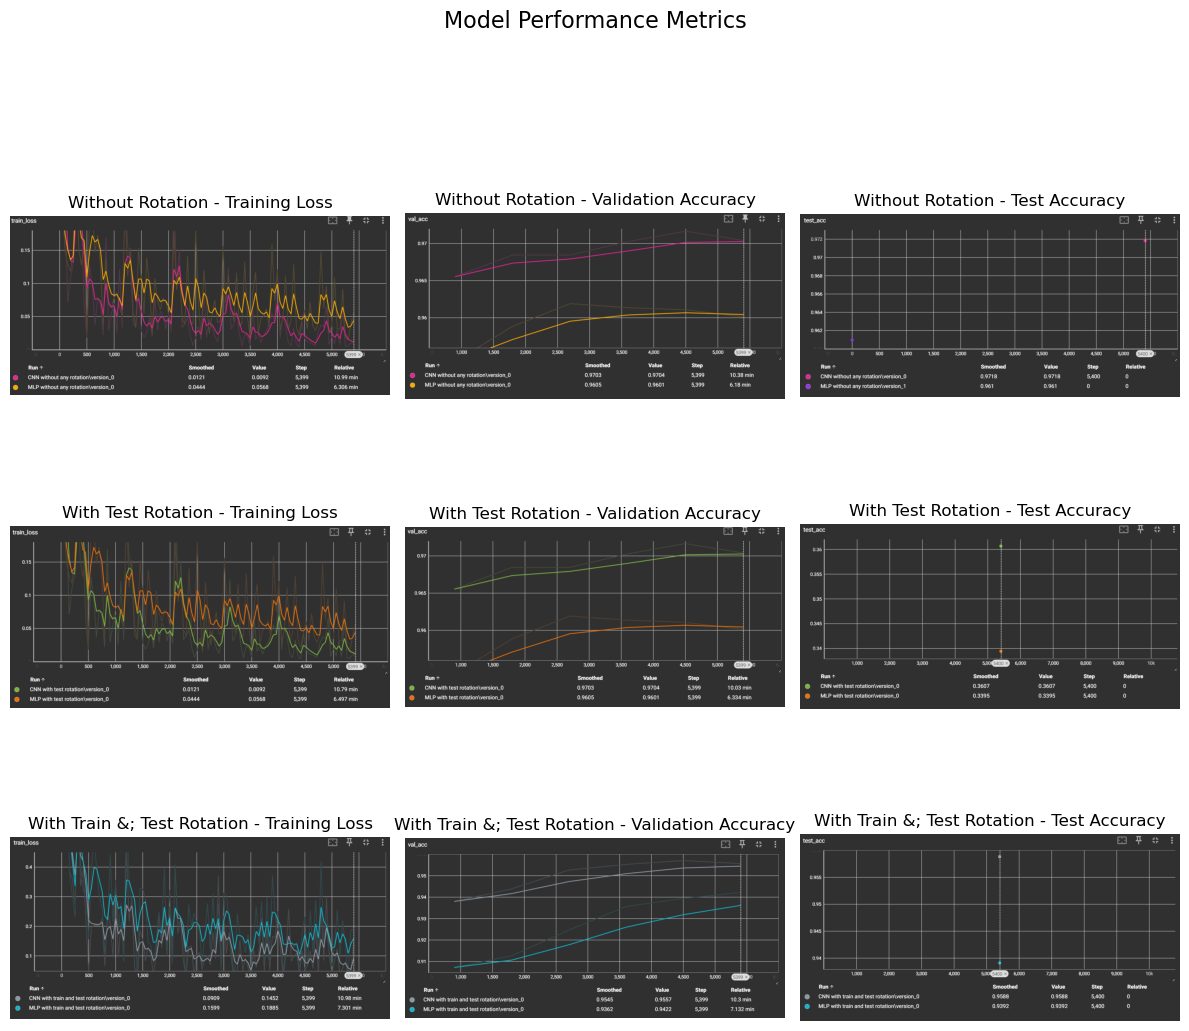

In [ ]:
image_paths = [
    'figures/without_rotation_train_loss.png', 
    'figures/without_rotation_val_acc.png', 
    'figures/without_rotation_test_acc.png',
    'figures/with_test_rotation_train_loss.png',
    'figures/with_test_rotation_val_acc.png',
    'figures/with_test_rotation_test_acc.png',
    'figures/with_train_rotation_train_loss.png',
    'figures/with_train_rotation_val_acc.png',
    'figures/with_train_rotation_test_acc.png'
]

titles = [
    'Without Rotation - Training Loss', 
    'Without Rotation - Validation Accuracy', 
    'Without Rotation - Test Accuracy',
    'With Test Rotation - Training Loss', 
    'With Test Rotation - Validation Accuracy', 
    'With Test Rotation - Test Accuracy',
    'With Train &; Test Rotation - Training Loss', 
    'With Train &; Test Rotation - Validation Accuracy', 
    'With Train &; Test Rotation - Test Accuracy'
]

fig, axs = plt.subplots(3, 3, figsize=(12, 12))

axs = axs.flatten()

for ax, img_path, title in zip(axs, image_paths, titles):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

plt.suptitle('Model Performance Metrics', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

##### Explanation: 
From the plots, we observe that the training loss remains relatively consistent across all three models. The validation accuracy is fairly similar for the models without rotation and with test rotation; however, it shows a significant increase when both training and test data are subjected to rotations. Additionally, while the validation accuracy for the first two models tends to decline toward the end of their respective training sessions, the third model continues to show an upward trend in validation accuracy even at the final step.

## More Augmentations

In [ ]:
!python project_main.py --train --evaluate --rotate-test --use-augmentations

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

       Test metric             DataLoader 0

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

        test_acc            0.3811666667461395

        test_loss            5.675966262817383

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params
------------------------------------------------------
0 | model          | CNN                | 421 K 
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
3 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.685     Total estimated model params size (MB)


##### Explanation:
As we can see, the new accuracy indicates that the model is struggling to generalize effectively under these new conditions. This decline may be attributed to increased variability introduced by the rotations, which could overwhelm the model if it hasn't been sufficiently trained on such transformations. Additionally, using aggressive rotation angles might lead to scenarios where the training images no longer represent typical orientations seen during testing.

## Analyzing the Error Source

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

       Test metric             DataLoader 0

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

        test_acc            0.9610000252723694

        test_loss           0.13543830811977386

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Balanced Accuracy: 0.9610
Accuracy per Class:
Class 0: 0.9120
Class 1: 0.9800
Class 2: 0.9800
Class 3: 0.9750
Class 4: 0.9700
Class 5: 0.9490


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


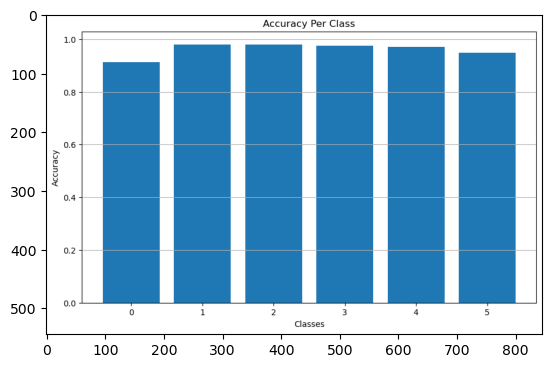

In [ ]:
!python project_main.py --evaluate --model-type MLP --checkpoint "lightning_logs\MLP with test rotation\version_0\checkpoints\epoch=5-step=5400.ckpt" --analyze-errors


img = mpimg.imread('figures/accuracy_per_class.png')
plt.imshow(img);


In [ ]:
!python project_main.py --evaluate --rotate-test --checkpoint "lightning_logs\CNN with train and test rotation\version_0\checkpoints\epoch=5-step=5400.ckpt"

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

       Test metric             DataLoader 0

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

        test_acc            0.9578333497047424

        test_loss           0.12141044437885284

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
